In [1]:
%matplotlib inline
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from SAMPEX_functions import read_counts as read
from SAMPEX_functions import mb_finder, read_days, mb_magnitude, iso_calculator, OrbAtt_augment_loop
import pandas as pd
import os
import pathlib
import string
import datetime
import scipy.stats

In [3]:
# defining files
storms = np.array(['1993047-1993053', '1993067-1993069', '1993070-1993071', '1993093-1993099', '1993127-1993133', '1993254-1993260', \
          '1993280-1993286', '1993306-1993312', '1993335-1993340'])

bad_storms = np.array(['1993127-1993133', '1993280-1993286', '1993335-1993340'])

for bad in bad_storms:
    storms = storms[storms != bad]

# reading in mag indices
# define mag indices data
#directory = 'E:\SAMPEX_Data\\'
directory = 'C:\\Users\\jacob\\Documents\\CU_Boulder\\Research\\LASP\\lasp-research\\sampexlib\\SAMPEX_Data\\'
file = 'mag_indices_1993.txt'
mag_indices = pd.read_csv(directory + file, header = None, delimiter='\s+')

# define day, hr, min, AE, and Dst
ind_day = np.array(mag_indices[1])
ind_hr = np.array(mag_indices[2])
ind_min = np.array(mag_indices[3])
t_ind = ind_day*3600*24 + ind_hr*3600 + ind_min*60

AE = np.array(mag_indices[4])
AE_max = np.max(AE)
Dst = np.array(mag_indices[5])

# find _ hr average of the AE indices
bin_size = 3              # in hours

AE_series = pd.Series(AE)
AE_perhrs = np.array(AE_series.rolling(bin_size*12, center=True).mean())

# defining month
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# code is specific for year 1993
OrbAtt_names = np.array(['OrbAtt_secofyear_1993001-1993012.txt', 'OrbAtt_secofyear_1993013-1993039.txt', 'OrbAtt_secofyear_1993040-1993066.txt', \
                         'OrbAtt_secofyear_1993067-1993093.txt', 'OrbAtt_secofyear_1993094-1993120.txt', 'OrbAtt_secofyear_1993121-1993147.txt', \
                         'OrbAtt_secofyear_1993148-1993174.txt', 'OrbAtt_secofyear_1993175-1993201.txt', 'OrbAtt_secofyear_1993202-1993228.txt', \
                         'OrbAtt_secofyear_1993229-1993255.txt', 'OrbAtt_secofyear_1993256-1993282.txt', 'OrbAtt_secofyear_1993283-1993309.txt', \
                         'OrbAtt_secofyear_1993310-1993336.txt', 'OrbAtt_secofyear_1993337-1993363.txt', 'OrbAtt_secofyear_1993364-1993365.txt'])

In [13]:
iso_MB_prestorm_list = np.array([])
iso_MB_mainphase_list = np.array([])
iso_MB_recovery_list = np.array([])
iso_BG_prestorm_list = np.array([])
iso_BG_mainphase_list = np.array([])
iso_BG_recovery_list = np.array([])

t_MB_list = np.array([])
AE_MB_list = np.array([])
iso_MB_AE_list = np.array([])
t_BG_list = np.array([])
AE_BG_list = np.array([])
iso_BG_AE_list = np.array([])

for storm in storms:
    print(f'Extracting data from storm {storm} ...')
    # defining file
    year = int(storm[0:4])
    start_day = int(storm[4:7])
    end_day = int(storm[12:])
    num_days = end_day - start_day + 1
    
    iso_MB_storm = np.array([])
    iso_BG_storm = np.array([])
    t_MB_storm = np.array([])
    t_BG_storm = np.array([])
    for day_of_year in np.arange(start_day, end_day+1):
        # name the day
        if len(str(day_of_year)) == 1:
            file = 'hhrr' + str(year) + '00' + str(day_of_year) + '.txt'
        elif len(str(day_of_year)) == 2:
            file = 'hhrr' + str(year) + '0' + str(day_of_year) + '.txt'
        elif len(str(day_of_year)) == 3:
            file = 'hhrr' + str(year) + str(day_of_year) + '.txt'

        # reading in electron counts files:
        t_electrons, r1, r2, r3, r4 = read(file)

        # reading in orbit/attitude data file
        OrbAtt_mask = []
        for i in np.arange(len(OrbAtt_names)):
            OrbAtt_mask.append(day_of_year >= int(OrbAtt_names[i][21:24]) and day_of_year <= int(OrbAtt_names[i][29:32]))
        
        OA_file = OrbAtt_names[OrbAtt_mask][0]
    
        directory = 'C:\\Users\\jacob\\Documents\\CU_Boulder\\Research\\LASP\\lasp-research\\sampexlib\\SAMPEX_Data\\1993_data\\'
        OrbAtt_file = pd.read_csv(directory + OA_file, names = ['day', 'hr', 'min', 'sec', 'GEO_Radius', 'GEO_Long', 'GEO_Lat', 'Altitude', 
                                                            'L_Shell', 'MLT', 'SAA_Flag', 'Pitch', 'zenith', 'azimuth', 'Att_Flag'], sep = '\s+', header = 70)
    
        # Augment OrbAtt data to fit counts data
        t_OrbAtt, LS_OrbAtt, MLT_OrbAtt, P_OrbAtt, Lat_OrbAtt, Long_OrbAtt, R_OrbAtt, t_electrons, r1, r2, r3, r4 = OrbAtt_augment_loop(t_electrons, r1, r2, r3, r4, OrbAtt_file, day_of_year)


        ############## mask for spatial/temporal regions ##############
        
        mask = (np.abs(90 - P_OrbAtt) >= 50) & (LS_OrbAtt >= 3) & (LS_OrbAtt <= 8)
        t_OrbAtt = t_OrbAtt[mask]; LS_OrbAtt = LS_OrbAtt[mask]; MLT_OrbAtt = MLT_OrbAtt[mask];
        P_OrbAtt = P_OrbAtt[mask]; Lat_OrbAtt = Lat_OrbAtt[mask]; Long_OrbAtt = Long_OrbAtt[mask];
        R_OrbAtt = R_OrbAtt[mask]; t_electrons = t_electrons[mask]; r1 = r1[mask]; r2 = r2[mask]; r3 = r3[mask]; r4 = r4[mask]

        ###############################################################
    
    
        # find microburst times and N_100, SSD1, SSD4 counts using algorithm
        t_microburst, N_100_microburst, r1_microburst, r4_microburst, mb_index, MB_mask, N_100, A_500 = mb_finder(t_electrons, r1, r2, r3, r4)

        # create background counts mask
        BG_mask = ~MB_mask

        # calculation of the isotropy indices of electron counts
        iso_indices_MB = iso_calculator(r1[MB_mask], r4[MB_mask])
        iso_indices_BG = iso_calculator(r1[BG_mask], r4[BG_mask])
    
        # find the OrbAtt and magnetic index microburst and backgound parameters
        if len(mb_index) > 0:
            t_OrbAtt_MB = t_OrbAtt[mb_index]
            t_MB = t_OrbAtt_MB + day_of_year*3600*24
            t_MB_storm = np.append(t_MB_storm, t_MB)
            iso_MB_storm = np.append(iso_MB_storm, iso_indices_MB)
        
        t_OrbAtt_BG = t_OrbAtt[BG_mask]
        t_BG = t_OrbAtt_BG + day_of_year*3600*24
        t_BG_storm = np.append(t_BG_storm, t_BG)
        iso_BG_storm = np.append(iso_BG_storm, iso_indices_BG)
    
    # mask indices for correct storm time period
    t_storm = (ind_hr*3600 + ind_min*60)[(ind_day >= start_day) & (ind_day <= end_day)]
    Dst_storm = Dst[(ind_day >= start_day) & (ind_day <= end_day)]
    
    # find _ hr average of the Dst indices
    bin_size = 1              # in hours
    interval = 24*num_days    # in hours

    t_perhrs = np.arange(0, interval*12, bin_size*12)
    index_perhrs = np.arange(bin_size*12-1, interval*12, bin_size*12)

    Dst_series = pd.Series(Dst_storm)
    Dst_perhrs = np.array(Dst_series.rolling(bin_size*12, center=False).min())[index_perhrs]
    
    # Isotropy-Dst study
    # categorize Dst indices
    t_max = t_perhrs[Dst_perhrs == np.max(Dst_perhrs)]; t_Dmax = [t_max] if isinstance(t_max, int) else t_max
    t_min = t_perhrs[Dst_perhrs == np.min(Dst_perhrs)]; t_Dmin = [t_min] if isinstance(t_min, int) else t_min
    
    t_Dmax_sec = t_Dmax[0]*300 + start_day*3600*24
    t_Dmin_sec = t_Dmin[0]*300 + start_day*3600*24

    # define stormtime regions
    iso_MB_prestorm = iso_MB_storm[t_MB_storm <= t_Dmax_sec]
    iso_BG_prestorm = iso_BG_storm[t_BG_storm <= t_Dmax_sec]
    
    iso_MB_mainphase = iso_MB_storm[(t_MB_storm >= t_Dmax_sec) & (t_MB_storm <= t_Dmin_sec)]
    iso_BG_mainphase = iso_BG_storm[(t_BG_storm >= t_Dmax_sec) & (t_BG_storm <= t_Dmin_sec)]
    
    iso_MB_recovery = iso_MB_storm[t_MB_storm >= t_Dmin_sec]
    iso_BG_recovery = iso_BG_storm[t_BG_storm >= t_Dmin_sec]
    
    # collect in epoch array
    iso_MB_prestorm_list = np.append(iso_MB_prestorm_list, iso_MB_prestorm)
    iso_MB_mainphase_list = np.append(iso_MB_mainphase_list, iso_MB_mainphase)
    iso_MB_recovery_list = np.append(iso_MB_recovery_list, iso_MB_recovery)
    
    iso_BG_prestorm_list = np.append(iso_BG_prestorm_list, iso_BG_prestorm)
    iso_BG_mainphase_list = np.append(iso_BG_mainphase_list, iso_BG_mainphase)
    iso_BG_recovery_list = np.append(iso_BG_recovery_list, iso_BG_recovery)

    # Isotropy-AE study
    # Align isotropy and AE values
    t_storm_MB = np.array([])
    AE_storm_MB = np.array([])
    for t in t_MB_storm:
        day = m.ceil(t/(3600*24))-1
        sec_of_day = (t-day*3600*24)
        hr = sec_of_day/3600
    
        if sec_of_day % 3600 != 0:
            hr_round = m.ceil(hr)-1
            minute = sec_of_day/60 - hr_round*60
            if minute % 5 != 0:
                five_min = (m.ceil(minute/5)-1)*5
            elif minute % 5 == 0:
                five_min = int(minute)

        elif sec_of_day % 3600 == 0:
            hr_round = int(hr)
            minute = 0
            five_min = 0
            
        if hr_round == 24:
            day_new = day + 1
            hr_round = 0
            t_AE_MB = t_ind[(ind_day == day_new) & (ind_hr == hr_round) & (ind_min == five_min)]
            AE_MB = AE_perhrs[(ind_day == day_new) & (ind_hr == hr_round) & (ind_min == five_min)]
        
        elif hr_round != 24:
            t_AE_MB = t_ind[(ind_day == day) & (ind_hr == hr_round) & (ind_min == five_min)]
            AE_MB = AE_perhrs[(ind_day == day) & (ind_hr == hr_round) & (ind_min == five_min)]
    
        t_storm_MB = np.append(t_storm_MB, t_AE_MB)
        AE_storm_MB = np.append(AE_storm_MB, AE_MB)

    t_storm_BG = np.array([])
    AE_storm_BG = np.array([])
    for t in t_BG_storm:
        day = m.ceil(t/(3600*24))-1
        sec_of_day = (t-day*3600*24)
        hr = sec_of_day/3600
    
        if sec_of_day % 3600 != 0:
            hr_round = m.ceil(hr)-1
            minute = sec_of_day/60 - hr_round*60
            if minute % 5 != 0:
                five_min = (m.ceil(minute/5)-1)*5
            elif minute % 5 == 0:
                five_min = int(minute)

        elif sec_of_day % 3600 == 0:
            hr_round = int(hr)
            minute = 0
            five_min = 0
            
        if hr_round == 24:
            day_new = day + 1
            hr_round = 0
            t_AE__BG = t_ind[(ind_day == day_new) & (ind_hr == hr_round) & (ind_min == five_min)]
            AE_BG = AE_perhrs[(ind_day == day_new) & (ind_hr == hr_round) & (ind_min == five_min)]
        
        elif hr_round != 24:
            t_AE_BG = t_ind[(ind_day == day) & (ind_hr == hr_round) & (ind_min == five_min)]
            AE_BG = AE_perhrs[(ind_day == day) & (ind_hr == hr_round) & (ind_min == five_min)]
    
        t_storm_BG = np.append(t_storm_BG, t_AE_BG)
        AE_storm_BG = np.append(AE_storm_BG, AE_BG)
    
    t_MB_list = np.append(t_MB_list, t_storm_MB)
    AE_MB_list = np.append(AE_MB_list, AE_storm_MB)
    iso_MB_AE_list = np.append(iso_MB_AE_list, iso_MB_storm)
    
    t_BG_list = np.append(t_BG_list, t_storm_BG)
    AE_BG_list = np.append(AE_BG_list, AE_storm_BG)
    iso_BG_AE_list = np.append(iso_BG_AE_list, iso_BG_storm)

Extracting data from storm 1993047-1993053 ...
Extracting data from storm 1993067-1993069 ...
Extracting data from storm 1993070-1993071 ...
Extracting data from storm 1993093-1993099 ...
Extracting data from storm 1993254-1993260 ...
Extracting data from storm 1993306-1993312 ...


In [15]:
# counts units = [counts/100ms]
def counts2flux(counts):
    ms2s = 1/1000
    geo_factor = 15
    flux = (counts/100)*(1/ms2s)*(1/geo_factor)
    
    return flux

In [16]:
# microbursts per storm period and flux magnitudes

mag_MB_prestorm_list = np.array([])
mag_MB_mainphase_list = np.array([])
mag_MB_recovery_list = np.array([])

for storm in storms:
    print(f'Extracting data from storm {storm} ...')
    # defining file
    year = int(storm[0:4])
    start_day = int(storm[4:7])
    end_day = int(storm[12:])
    num_days = end_day - start_day + 1
    
    num_MB_storm = np.array([])
    mag_MB_storm = np.array([])
    t_MB_storm = np.array([])

    for day_of_year in np.arange(start_day, end_day+1):
        # name the day
        if len(str(day_of_year)) == 1:
            file = 'hhrr' + str(year) + '00' + str(day_of_year) + '.txt'
        elif len(str(day_of_year)) == 2:
            file = 'hhrr' + str(year) + '0' + str(day_of_year) + '.txt'
        elif len(str(day_of_year)) == 3:
            file = 'hhrr' + str(year) + str(day_of_year) + '.txt'

        # reading in electron counts files:
        t_electrons, r1, r2, r3, r4 = read(file)

        # reading in orbit/attitude data file
        OrbAtt_mask = []
        for i in np.arange(len(OrbAtt_names)):
            OrbAtt_mask.append(day_of_year >= int(OrbAtt_names[i][21:24]) and day_of_year <= int(OrbAtt_names[i][29:32]))
        
        OA_file = OrbAtt_names[OrbAtt_mask][0]
    
        directory = 'C:\\Users\\jacob\\Documents\\CU_Boulder\\Research\\LASP\\lasp-research\\sampexlib\\SAMPEX_Data\\1993_data\\'
        OrbAtt_file = pd.read_csv(directory + OA_file, names = ['day', 'hr', 'min', 'sec', 'GEO_Radius', 'GEO_Long', 'GEO_Lat', 'Altitude', 
                                                            'L_Shell', 'MLT', 'SAA_Flag', 'Pitch', 'zenith', 'azimuth', 'Att_Flag'], sep = '\s+', header = 70)
    
        # Augment OrbAtt data to fit counts data
        t_OrbAtt, LS_OrbAtt, MLT_OrbAtt, P_OrbAtt, Lat_OrbAtt, Long_OrbAtt, R_OrbAtt, t_electrons, r1, r2, r3, r4 = OrbAtt_augment_loop(t_electrons, r1, r2, r3, r4, OrbAtt_file, day_of_year)


        ############## mask for spatial/temporal regions ##############
        
        mask = (np.abs(90 - P_OrbAtt) >= 50) & (LS_OrbAtt >= 3) & (LS_OrbAtt <= 8)
        t_OrbAtt = t_OrbAtt[mask]; LS_OrbAtt = LS_OrbAtt[mask]; MLT_OrbAtt = MLT_OrbAtt[mask];
        P_OrbAtt = P_OrbAtt[mask]; Lat_OrbAtt = Lat_OrbAtt[mask]; Long_OrbAtt = Long_OrbAtt[mask];
        R_OrbAtt = R_OrbAtt[mask]; t_electrons = t_electrons[mask]; r1 = r1[mask]; r2 = r2[mask]; r3 = r3[mask]; r4 = r4[mask]

        ###############################################################
    
    
        # find microburst times and N_100, SSD1, SSD4 counts using algorithm
        t_microburst, N_100_microburst, r1_microburst, r4_microburst, mb_index, MB_mask, N_100, A_500 = mb_finder(t_electrons, r1, r2, r3, r4)
        
        
        # calculation of B_3 bin percentiles
        mag_MB, B_3_microburst, B_3 = mb_magnitude(N_100, N_100_microburst, A_500)
    
        ### COUNTS TO FLUX CONVERT ###
        mag_MB = counts2flux(mag_MB)
    
        # find the OrbAtt and magnetic index microburst and backgound parameters
        if len(mb_index) > 0:
            t_OrbAtt_MB = t_OrbAtt[mb_index]
            t_MB = t_OrbAtt_MB + day_of_year*3600*24
            t_MB_storm = np.append(t_MB_storm, t_MB)
            mag_MB_storm = np.append(mag_MB_storm, mag_MB)
    
    # mask indices for correct storm time period
    t_storm = (ind_hr*3600 + ind_min*60)[(ind_day >= start_day) & (ind_day <= end_day)]
    Dst_storm = Dst[(ind_day >= start_day) & (ind_day <= end_day)]
    
    # find _ hr average of the Dst indices
    bin_size = 1              # in hours
    interval = 24*num_days    # in hours

    t_perhrs = np.arange(0, interval*12, bin_size*12)
    index_perhrs = np.arange(bin_size*12-1, interval*12, bin_size*12)

    Dst_series = pd.Series(Dst_storm)
    Dst_perhrs = np.array(Dst_series.rolling(bin_size*12, center=False).min())[index_perhrs]
    
    # Magnitude-Dst study
    # categorize Dst indices
    t_max = t_perhrs[Dst_perhrs == np.max(Dst_perhrs)]; t_Dmax = [t_max] if isinstance(t_max, int) else t_max
    t_min = t_perhrs[Dst_perhrs == np.min(Dst_perhrs)]; t_Dmin = [t_min] if isinstance(t_min, int) else t_min
    
    t_Dmax_sec = t_Dmax[0]*300 + start_day*3600*24
    t_Dmin_sec = t_Dmin[0]*300 + start_day*3600*24

    # define stormtime regions
    mag_MB_prestorm = mag_MB_storm[t_MB_storm <= t_Dmax_sec]
    mag_MB_mainphase = mag_MB_storm[(t_MB_storm >= t_Dmax_sec) & (t_MB_storm <= t_Dmin_sec)]
    mag_MB_recovery = mag_MB_storm[t_MB_storm >= t_Dmin_sec]

    # collect in epoch array
    mag_MB_prestorm_list = np.append(mag_MB_prestorm_list, mag_MB_prestorm)
    mag_MB_mainphase_list = np.append(mag_MB_mainphase_list, mag_MB_mainphase)
    mag_MB_recovery_list = np.append(mag_MB_recovery_list, mag_MB_recovery)

Extracting data from storm 1993047-1993053 ...
Extracting data from storm 1993067-1993069 ...
Extracting data from storm 1993070-1993071 ...
Extracting data from storm 1993093-1993099 ...
Extracting data from storm 1993254-1993260 ...
Extracting data from storm 1993306-1993312 ...


Median microburst flux magnitudes for the 6 storms:

Initial phase: 2850.93
Main phase: 2432.87
Recovery phase: 2343.47

Average microburst flux magnitudes for the 6 storms:

Initial phase: 4684.67
Main phase: 4228.99
Recovery phase: 4187.99



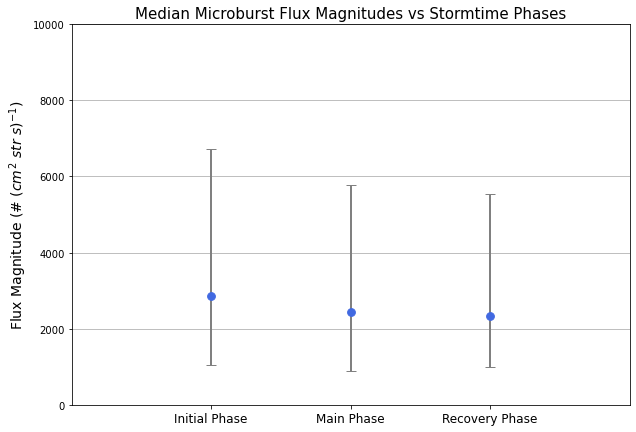

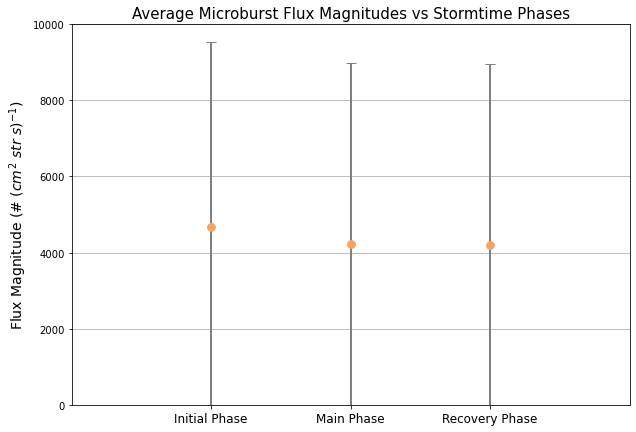

In [33]:
# calculate average mb iso vs storm phases
labels = np.array(['Initial Phase', 'Main Phase', 'Recovery Phase'])
labels_x = np.array([1.0,2.0,3.0])

mag_MB_med = np.array([np.nanmedian(mag_MB_prestorm_list), np.nanmedian(mag_MB_mainphase_list), np.nanmedian(mag_MB_recovery_list)])
mag_MB_75error = np.array([
    np.nanpercentile(mag_MB_prestorm_list, 75) - mag_MB_med[0],
    np.nanpercentile(mag_MB_mainphase_list, 75) - mag_MB_med[1],
    np.nanpercentile(mag_MB_recovery_list, 75) - mag_MB_med[2]
])
mag_MB_25error = np.array([
    mag_MB_med[0] - np.nanpercentile(mag_MB_prestorm_list, 25),
    mag_MB_med[1] - np.nanpercentile(mag_MB_mainphase_list, 25),
    mag_MB_med[2] - np.nanpercentile(mag_MB_recovery_list, 25)
])

mag_MB_avgs = np.array([np.nanmean(mag_MB_prestorm_list), np.nanmean(mag_MB_mainphase_list), np.nanmean(mag_MB_recovery_list)])
mag_MB_std = np.array([np.nanstd(mag_MB_prestorm_list), np.nanstd(mag_MB_mainphase_list), np.nanstd(mag_MB_recovery_list)])

print(f'Median microburst flux magnitudes for the 6 storms:\n\nInitial phase: {mag_MB_med[0]:.2f}\nMain phase: \
{mag_MB_med[1]:.2f}\nRecovery phase: {mag_MB_med[2]:.2f}\n')

print(f'Average microburst flux magnitudes for the 6 storms:\n\nInitial phase: {mag_MB_avgs[0]:.2f}\nMain phase: \
{mag_MB_avgs[1]:.2f}\nRecovery phase: {mag_MB_avgs[2]:.2f}\n')

plt.figure(figsize = (10,7))
plt.title(f'Median Microburst Flux Magnitudes vs Stormtime Phases', fontsize = 15)

plt.scatter(labels_x, mag_MB_med, c='royalblue', s = 60, zorder=3)
plt.errorbar(labels_x, mag_MB_med, yerr = np.array([mag_MB_25error, mag_MB_75error]), fmt='none', \
             elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)

plt.xlim(0, np.max(labels_x)+1.0)
plt.xticks(ticks=labels_x, labels=labels, fontsize=12)
plt.ylim(0,10000)
plt.ylabel('Flux Magnitude (# $(cm^2$ $str$ $s)^{-1}$)', fontsize=14)
plt.grid(axis='y')

plt.figure(figsize = (10,7))
plt.title(f'Average Microburst Flux Magnitudes vs Stormtime Phases', fontsize = 15)

plt.scatter(labels_x, mag_MB_avgs, c='sandybrown', s = 60, zorder=3)
plt.errorbar(labels_x, mag_MB_avgs, yerr = mag_MB_std, fmt='none', elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)

plt.xlim(0, np.max(labels_x)+1.0)
plt.xticks(ticks=labels_x, labels=labels, fontsize=12)
plt.ylim(0,10000)
plt.ylabel('Flux Magnitude (# $(cm^2$ $str$ $s)^{-1}$)', fontsize=14)
plt.grid(axis='y')

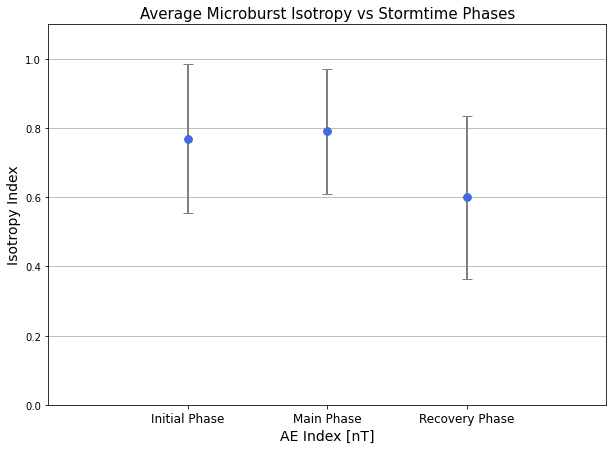

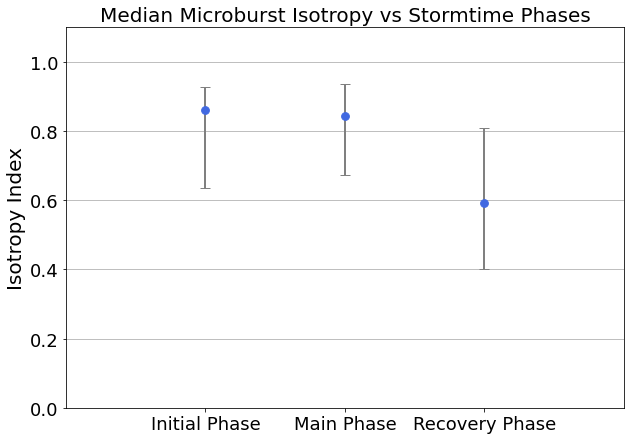

In [7]:
# calculate average mb iso vs storm phases
labels = np.array(['Initial Phase', 'Main Phase', 'Recovery Phase'])
labels_x = np.array([1.0,2.0,3.0])

iso_MB_avgs_Dst = np.array([np.nanmean(iso_MB_prestorm_list), np.nanmean(iso_MB_mainphase_list), np.nanmean(iso_MB_recovery_list)])
iso_MB_std_Dst = np.array([np.nanstd(iso_MB_prestorm_list), np.nanstd(iso_MB_mainphase_list), np.nanstd(iso_MB_recovery_list)])

plt.figure(figsize = (10,7))
plt.title(f'Average Microburst Isotropy vs Stormtime Phases', fontsize = 15)
plt.scatter(labels_x, iso_MB_avgs_Dst, c='royalblue', s = 60, zorder=3)
plt.errorbar(labels_x, iso_MB_avgs_Dst, yerr = iso_MB_std_Dst, fmt='none', elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(labels_x)+1.0)
plt.xticks(ticks=labels_x, labels=labels, fontsize=12)
plt.xlabel('AE Index [nT]', fontsize=14)
plt.ylim(0,1.1)
plt.ylabel('Isotropy Index', fontsize=14)
plt.grid(axis='y')

# calculate median mb iso vs storm phases
labels = np.array(['Initial Phase', 'Main Phase', 'Recovery Phase'])
labels_x = np.array([1.0,2.0,3.0])

iso_MB_med_Dst = np.array([np.nanmedian(iso_MB_prestorm_list), np.nanmedian(iso_MB_mainphase_list), np.nanmedian(iso_MB_recovery_list)])
iso_MB_75error_Dst = np.array([
    np.nanpercentile(iso_MB_prestorm_list, 75) - iso_MB_med_Dst[0],
    np.nanpercentile(iso_MB_mainphase_list, 75) - iso_MB_med_Dst[1],
    np.nanpercentile(iso_MB_recovery_list, 75) - iso_MB_med_Dst[2]
])
iso_MB_25error_Dst = np.array([
    iso_MB_med_Dst[0] - np.nanpercentile(iso_MB_prestorm_list, 25),
    iso_MB_med_Dst[1] - np.nanpercentile(iso_MB_mainphase_list, 25),
    iso_MB_med_Dst[2] - np.nanpercentile(iso_MB_recovery_list, 25)
])

plt.figure(figsize = (10,7))
plt.title(f'Median Microburst Isotropy vs Stormtime Phases', fontsize = 20)
plt.scatter(labels_x, iso_MB_med_Dst, c='royalblue', s = 60, zorder=3)
plt.errorbar(labels_x, iso_MB_med_Dst, yerr = np.array([iso_MB_25error_Dst, iso_MB_75error_Dst]), fmt='none', \
             elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(labels_x)+1.0)
plt.xticks(ticks=labels_x, labels=labels, fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0,1.1)
plt.ylabel('Isotropy Index', fontsize=20)
plt.grid(axis='y')

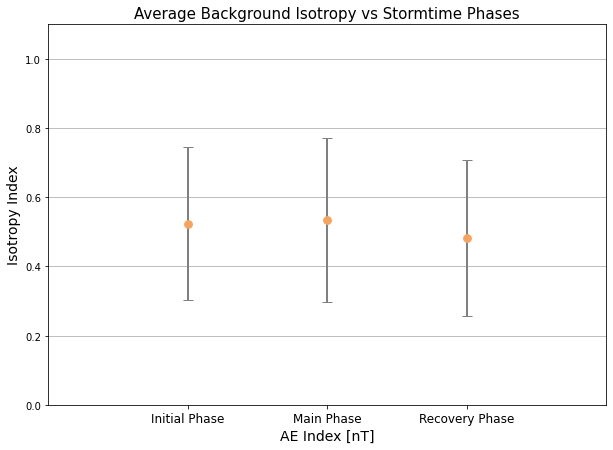

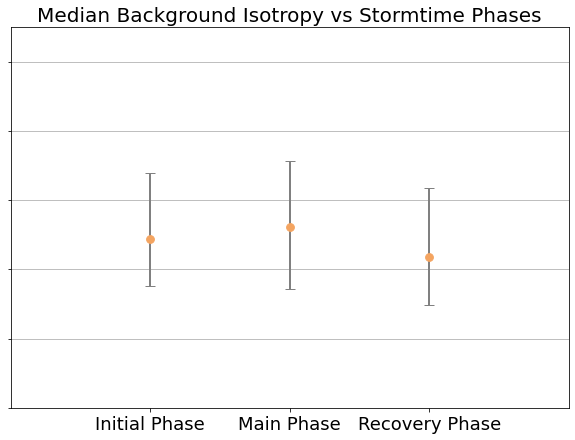

In [8]:
# calculate average bg iso vs storm phases
labels = np.array(['Initial Phase', 'Main Phase', 'Recovery Phase'])
labels_x = np.array([1.0,2.0,3.0])

iso_BG_avgs_Dst = np.array([np.nanmean(iso_BG_prestorm_list), np.nanmean(iso_BG_mainphase_list), np.nanmean(iso_BG_recovery_list)])
iso_BG_std_Dst = np.array([np.nanstd(iso_BG_prestorm_list), np.nanstd(iso_BG_mainphase_list), np.nanstd(iso_BG_recovery_list)])

plt.figure(figsize = (10,7))
plt.title(f'Average Background Isotropy vs Stormtime Phases', fontsize = 15)
plt.scatter(labels_x, iso_BG_avgs_Dst, c='sandybrown', s = 60, zorder=3)
plt.errorbar(labels_x, iso_BG_avgs_Dst, yerr = iso_BG_std_Dst, fmt='none', elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(labels_x)+1)
plt.xticks(ticks=labels_x, labels=labels, fontsize=12)
plt.xlabel('AE Index [nT]', fontsize=14)
plt.ylim(0,1.1)
plt.ylabel('Isotropy Index', fontsize=14)
plt.grid(axis='y')

# calculate median bg iso vs storm phases
labels = np.array(['Initial Phase', 'Main Phase', 'Recovery Phase'])
labels_x = np.array([1.0,2.0,3.0])

iso_BG_med_Dst = np.array([np.nanmedian(iso_BG_prestorm_list), np.nanmedian(iso_BG_mainphase_list), np.nanmedian(iso_BG_recovery_list)])
iso_BG_75error_Dst = np.array([
    np.nanpercentile(iso_BG_prestorm_list, 75) - iso_BG_med_Dst[0],
    np.nanpercentile(iso_BG_mainphase_list, 75) - iso_BG_med_Dst[1],
    np.nanpercentile(iso_BG_recovery_list, 75) - iso_BG_med_Dst[2]
])
iso_BG_25error_Dst = np.array([
    iso_BG_med_Dst[0] - np.nanpercentile(iso_BG_prestorm_list, 25),
    iso_BG_med_Dst[1] - np.nanpercentile(iso_BG_mainphase_list, 25),
    iso_BG_med_Dst[2] - np.nanpercentile(iso_BG_recovery_list, 25)
])

plt.figure(figsize = (10,7))
plt.title(f'Median Background Isotropy vs Stormtime Phases', fontsize = 20)
plt.scatter(labels_x, iso_BG_med_Dst, c='sandybrown', s = 60, zorder=3)
plt.errorbar(labels_x, iso_BG_med_Dst, yerr = np.array([iso_BG_25error_Dst, iso_BG_75error_Dst]), fmt='none', elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(labels_x)+1)
plt.xticks(ticks=labels_x, labels=labels, fontsize=18)

ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])

#plt.yticks(fontsize=15)
plt.ylim(0,1.1)
#plt.ylabel('Isotropy Index', fontsize=18)
plt.grid(axis='y')

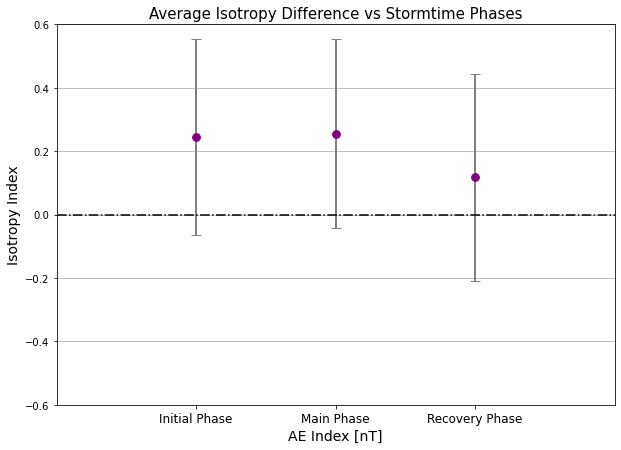

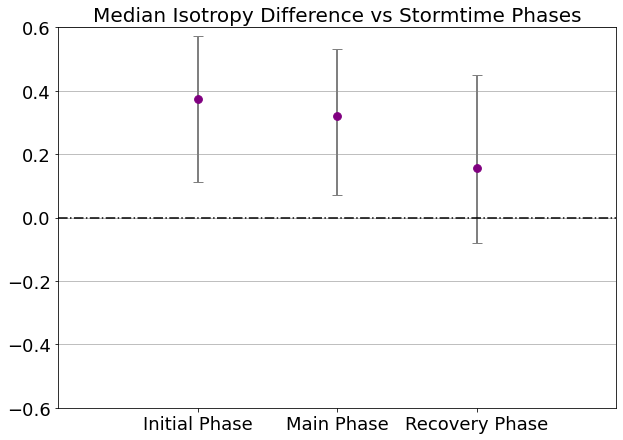

In [9]:
# calculate average iso diff vs storm phases
iso_diff = iso_MB_avgs_Dst - iso_BG_avgs_Dst
error_prop = np.sqrt(iso_MB_std_Dst**2 + iso_BG_std_Dst**2)

plt.figure(figsize = (10,7))
plt.title(f'Average Isotropy Difference vs Stormtime Phases', fontsize = 15)
plt.plot([0,np.max(labels_x)+1], [0,0], color='k', linestyle='-.')
plt.scatter(labels_x, iso_diff, c='purple', s = 60, zorder=3)
plt.errorbar(labels_x, iso_diff, yerr = error_prop, fmt='none', elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(labels_x)+1)
plt.xticks(ticks=labels_x, labels=labels, fontsize=12)
plt.xlabel('AE Index [nT]', fontsize=14)
plt.ylim(-0.6,0.6)
plt.ylabel('Isotropy Index', fontsize=14)
plt.grid(axis='y')

# calculate average iso diff vs storm phases
iso_diff = iso_MB_med_Dst - iso_BG_med_Dst
error75_prop = np.sqrt(iso_MB_75error_Dst**2 + iso_BG_75error_Dst**2)
error25_prop = np.sqrt(iso_MB_25error_Dst**2 + iso_BG_25error_Dst**2)

plt.figure(figsize = (10,7))
plt.title(f'Median Isotropy Difference vs Stormtime Phases', fontsize = 20)
plt.plot([0,np.max(labels_x)+1], [0,0], color='k', linestyle='-.')
plt.scatter(labels_x, iso_diff, c='purple', s = 60, zorder=3)
plt.errorbar(labels_x, iso_diff, yerr = np.array([error25_prop, error75_prop]), fmt='none', elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(labels_x)+1)
plt.xticks(ticks=labels_x, labels=labels, fontsize=18)

#ax = plt.gca()
#ax.axes.yaxis.set_ticklabels([])

plt.yticks(fontsize=18)
plt.ylim(-0.6,0.6)
#plt.ylabel('Isotropy Index', fontsize=18)
plt.grid(axis='y')

Number of microbursts in 0-100AE range: 201
Number of microbursts in 100-200AE range: 352
Number of microbursts in 200-300AE range: 640
Number of microbursts in 300-400AE range: 1593
Number of microbursts in 400-500AE range: 2617
Number of microbursts in 500-600AE range: 1569
Number of microbursts in 600-700AE range: 1529
Number of microbursts in 700-800AE range: 1379
Number of microbursts in 800-900AE range: 832
Number of microbursts in 900-1000AE range: 474


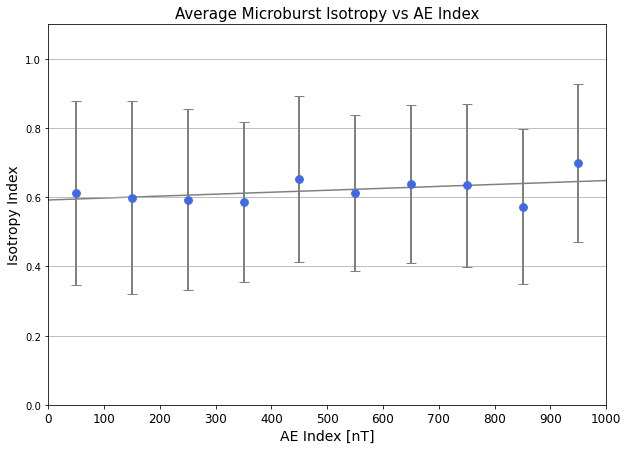

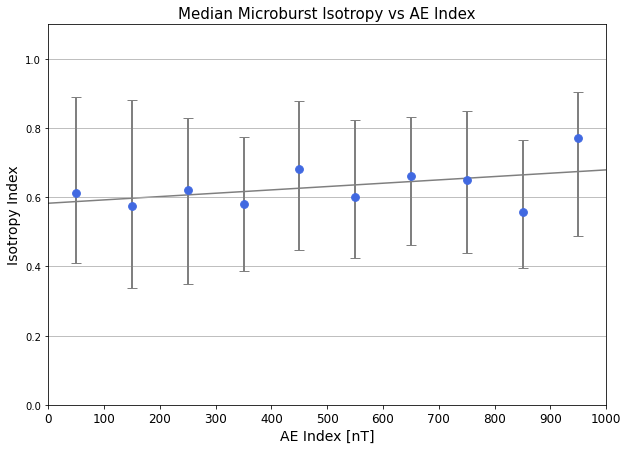

In [10]:
# calculate average mb iso vs AE
AE_max = int(m.ceil(np.max(AE_storm_MB)/100)*100)
bin_num = 10
AE_bins = np.linspace(0, AE_max, num=bin_num+1)

iso_MB_avgs_AE = np.array([])
iso_MB_std_AE = np.array([])
AE_MB_bin_centers = np.array([])
for i in np.arange(len(AE_bins)):
    if i == len(AE_bins)-1:
        break
    print(f'Number of microbursts in {int(AE_bins[i])}-{int(AE_bins[i+1])}'\
          f'AE range: {len(iso_MB_AE_list[(AE_MB_list>=AE_bins[i]) & (AE_MB_list<AE_bins[i+1])])}')
    
    if len(iso_MB_AE_list[(AE_MB_list>=AE_bins[i]) & (AE_MB_list<AE_bins[i+1])]) >= 100:
        iso_MB_avgs_i = np.nanmean(iso_MB_AE_list[(AE_MB_list>=AE_bins[i]) & (AE_MB_list<AE_bins[i+1])])
        iso_MB_std_i = np.nanstd(iso_MB_AE_list[(AE_MB_list>=AE_bins[i]) & (AE_MB_list<AE_bins[i+1])])
        AE_MB_bin_center_i = np.mean(np.array([AE_bins[i], AE_bins[i+1]]))
    
    elif len(iso_MB_AE_list[(AE_MB_list>=AE_bins[i]) & (AE_MB_list<AE_bins[i+1])]) < 100:
        iso_MB_avgs_i = np.nan
        iso_MB_std_i = np.nan
        AE_MB_bin_center_i = np.nan
    
    iso_MB_avgs_AE = np.append(iso_MB_avgs_AE, iso_MB_avgs_i)
    iso_MB_std_AE = np.append(iso_MB_std_AE, iso_MB_std_i)
    AE_MB_bin_centers = np.append(AE_MB_bin_centers, AE_MB_bin_center_i)
    
plt.figure(figsize = (10,7))
plt.title(f'Average Microburst Isotropy vs AE Index', fontsize = 15)

# trendline #
idx = np.isfinite(AE_MB_bin_centers) & np.isfinite(iso_MB_avgs_AE)
z = np.polyfit(AE_MB_bin_centers[idx], iso_MB_avgs_AE[idx], 1)
p = np.poly1d(z)
x_p = np.linspace(0, np.max(AE_bins))
plt.plot(x_p,p(x_p), color='k', linestyle='-', alpha=0.5, zorder=1)
# trendline #

plt.scatter(AE_MB_bin_centers, iso_MB_avgs_AE, c='royalblue', s = 60, zorder=3)
plt.errorbar(AE_MB_bin_centers, iso_MB_avgs_AE, yerr = iso_MB_std_AE, fmt='none', elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(AE_bins))
plt.xticks(ticks=AE_bins, fontsize=12)
plt.xlabel('AE Index [nT]', fontsize=14)
plt.ylim(0,1.1)
plt.ylabel('Isotropy Index', fontsize=14)
plt.grid(axis='y')

# calculate median mb iso vs AE
AE_max = int(m.ceil(np.max(AE_storm_MB)/100)*100)
bin_num = 10
AE_bins = np.linspace(0, AE_max, num=bin_num+1)

iso_MB_med_AE = np.array([])
iso_MB_75error_AE = np.array([])
iso_MB_25error_AE = np.array([])
AE_MB_bin_centers = np.array([])
for i in np.arange(len(AE_bins)):
    if i == len(AE_bins)-1:
        break
    
    if len(iso_MB_AE_list[(AE_MB_list>=AE_bins[i]) & (AE_MB_list<AE_bins[i+1])]) >= 100:
        iso_MB_med_i = np.nanmedian(iso_MB_AE_list[(AE_MB_list>=AE_bins[i]) & (AE_MB_list<AE_bins[i+1])])
        iso_MB_75error_i = np.nanpercentile(iso_MB_AE_list[(AE_MB_list>=AE_bins[i]) & (AE_MB_list<AE_bins[i+1])], 75) - iso_MB_med_i
        iso_MB_25error_i = iso_MB_med_i - np.nanpercentile(iso_MB_AE_list[(AE_MB_list>=AE_bins[i]) & (AE_MB_list<AE_bins[i+1])], 25)
        AE_MB_bin_center_i = np.mean(np.array([AE_bins[i], AE_bins[i+1]]))
    
    elif len(iso_MB_AE_list[(AE_MB_list>=AE_bins[i]) & (AE_MB_list<AE_bins[i+1])]) < 100:
        iso_MB_med_i = np.nan
        iso_MB_75error_i = np.nan
        iso_MB_25error_i = np.nan
        AE_MB_bin_center_i = np.nan
    
    iso_MB_med_AE = np.append(iso_MB_med_AE, iso_MB_med_i)
    iso_MB_75error_AE = np.append(iso_MB_75error_AE, iso_MB_75error_i)
    iso_MB_25error_AE = np.append(iso_MB_25error_AE, iso_MB_25error_i)
    AE_MB_bin_centers = np.append(AE_MB_bin_centers, AE_MB_bin_center_i)
    
plt.figure(figsize = (10,7))
plt.title(f'Median Microburst Isotropy vs AE Index', fontsize = 15)

# trendline #
idx = np.isfinite(AE_MB_bin_centers) & np.isfinite(iso_MB_med_AE)
z = np.polyfit(AE_MB_bin_centers[idx], iso_MB_med_AE[idx], 1)
p = np.poly1d(z)
x_p = np.linspace(0, np.max(AE_bins))
plt.plot(x_p,p(x_p), color='k', linestyle='-', alpha=0.5, zorder=1)
# trendline #

plt.scatter(AE_MB_bin_centers, iso_MB_med_AE, c='royalblue', s = 60, zorder=3)
plt.errorbar(AE_MB_bin_centers, iso_MB_med_AE, yerr = np.array([iso_MB_25error_AE, iso_MB_75error_AE]), fmt='none', \
             elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(AE_bins))
plt.xticks(ticks=AE_bins, fontsize=12)
plt.xlabel('AE Index [nT]', fontsize=14)
plt.ylim(0,1.1)
plt.ylabel('Isotropy Index', fontsize=14)
plt.grid(axis='y')

Number of background samples in 0-100AE-range: 959819
Number of background samples in 100-200AE-range: 685203
Number of background samples in 200-300AE-range: 502130
Number of background samples in 300-400AE-range: 467892
Number of background samples in 400-500AE-range: 442558
Number of background samples in 500-600AE-range: 294891
Number of background samples in 600-700AE-range: 213781
Number of background samples in 700-800AE-range: 184521
Number of background samples in 800-900AE-range: 92718
Number of background samples in 900-1000AE-range: 41266


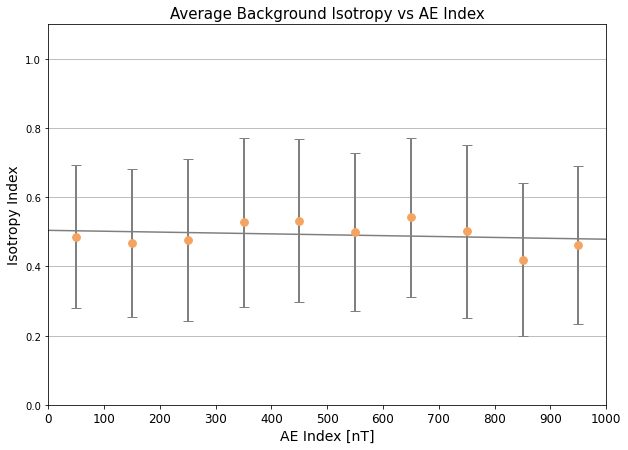

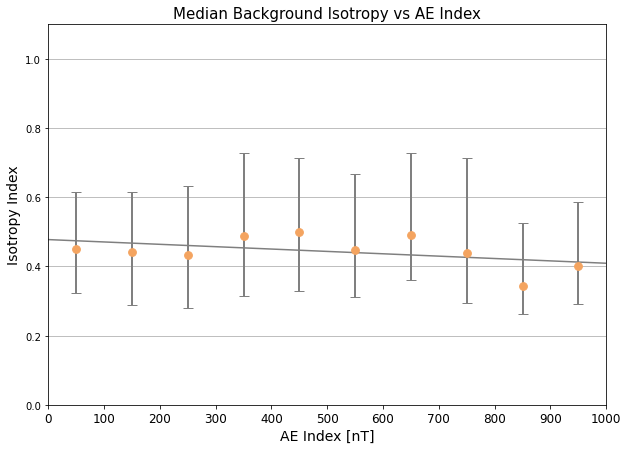

In [11]:
# calculate average bg iso vs AE
AE_max = int(m.ceil(np.max(AE_storm_MB)/100)*100)
bin_num = 10
AE_bins = np.linspace(0, AE_max, num=bin_num+1)

iso_BG_avgs_AE = np.array([])
iso_BG_std_AE = np.array([])
AE_BG_bin_centers = np.array([])
for i in np.arange(len(AE_bins)):
    if i == len(AE_bins)-1:
        break
    print(f'Number of background samples in {int(AE_bins[i])}-{int(AE_bins[i+1])}'\
          f'AE-range: {len(iso_BG_AE_list[(AE_BG_list>=AE_bins[i]) & (AE_BG_list<AE_bins[i+1])])}')
    
    if len(iso_BG_AE_list[(AE_BG_list>=AE_bins[i]) & (AE_BG_list<AE_bins[i+1])]) >= 100:
        iso_BG_avgs_i = np.nanmean(iso_BG_AE_list[(AE_BG_list>=AE_bins[i]) & (AE_BG_list<AE_bins[i+1])])
        iso_BG_std_i = np.nanstd(iso_BG_AE_list[(AE_BG_list>=AE_bins[i]) & (AE_BG_list<AE_bins[i+1])])
        AE_BG_bin_center_i = np.mean(np.array([AE_bins[i], AE_bins[i+1]]))
    
    elif len(iso_BG_AE_list[(AE_BG_list>=AE_bins[i]) & (AE_BG_list<AE_bins[i+1])]) < 100:
        iso_BG_avgs_i = np.nan
        iso_BG_std_i = np.nan
        AE_BG_bin_center_i = np.nan
    
    iso_BG_avgs_AE = np.append(iso_BG_avgs_AE, iso_BG_avgs_i)
    iso_BG_std_AE = np.append(iso_BG_std_AE, iso_BG_std_i)
    AE_BG_bin_centers = np.append(AE_BG_bin_centers, AE_BG_bin_center_i)
    
plt.figure(figsize = (10,7))
plt.title(f'Average Background Isotropy vs AE Index', fontsize = 15)

# trendline #
idx = np.isfinite(AE_BG_bin_centers) & np.isfinite(iso_BG_avgs_AE)
z = np.polyfit(AE_BG_bin_centers[idx], iso_BG_avgs_AE[idx], 1)
p = np.poly1d(z)
x_p = np.linspace(0, np.max(AE_bins))
plt.plot(x_p,p(x_p), color='k', linestyle='-', alpha=0.5, zorder=1)
# trendline #

plt.scatter(AE_BG_bin_centers, iso_BG_avgs_AE, c='sandybrown', s = 60, zorder=3)
plt.errorbar(AE_BG_bin_centers, iso_BG_avgs_AE, yerr = iso_BG_std_AE, fmt='none', elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(AE_bins))
plt.xticks(ticks=AE_bins, fontsize=12)
plt.xlabel('AE Index [nT]', fontsize=14)
plt.ylim(0,1.1)
plt.ylabel('Isotropy Index', fontsize=14)
plt.grid(axis='y')

# calculate median bg iso vs AE
AE_max = int(m.ceil(np.max(AE_storm_MB)/100)*100)
bin_num = 10
AE_bins = np.linspace(0, AE_max, num=bin_num+1)

iso_BG_med_AE = np.array([])
iso_BG_75error_AE = np.array([])
iso_BG_25error_AE = np.array([])
AE_BG_bin_centers = np.array([])
for i in np.arange(len(AE_bins)):
    if i == len(AE_bins)-1:
        break
    
    if len(iso_BG_AE_list[(AE_BG_list>=AE_bins[i]) & (AE_BG_list<AE_bins[i+1])]) >= 100:
        iso_BG_med_i = np.nanmedian(iso_BG_AE_list[(AE_BG_list>=AE_bins[i]) & (AE_BG_list<AE_bins[i+1])])
        iso_BG_75error_i = np.nanpercentile(iso_BG_AE_list[(AE_BG_list>=AE_bins[i]) & (AE_BG_list<AE_bins[i+1])], 75) - iso_BG_med_i
        iso_BG_25error_i = iso_BG_med_i - np.nanpercentile(iso_BG_AE_list[(AE_BG_list>=AE_bins[i]) & (AE_BG_list<AE_bins[i+1])], 25)
        AE_BG_bin_center_i = np.mean(np.array([AE_bins[i], AE_bins[i+1]]))
    
    elif len(iso_BG_AE_list[(AE_BG_list>=AE_bins[i]) & (AE_BG_list<AE_bins[i+1])]) < 100:
        iso_BG_med_i = np.nan
        iso_BG_75error_i = np.nan
        iso_BG_25error_i = np.nan
        AE_BG_bin_center_i = np.nan
    
    iso_BG_med_AE = np.append(iso_BG_med_AE, iso_BG_med_i)
    iso_BG_75error_AE = np.append(iso_BG_75error_AE, iso_BG_75error_i)
    iso_BG_25error_AE = np.append(iso_BG_25error_AE, iso_BG_25error_i)
    AE_BG_bin_centers = np.append(AE_BG_bin_centers, AE_BG_bin_center_i)
    
plt.figure(figsize = (10,7))
plt.title(f'Median Background Isotropy vs AE Index', fontsize = 15)

# trendline #
idx = np.isfinite(AE_BG_bin_centers) & np.isfinite(iso_BG_med_AE)
z = np.polyfit(AE_BG_bin_centers[idx], iso_BG_med_AE[idx], 1)
p = np.poly1d(z)
x_p = np.linspace(0, np.max(AE_bins))
plt.plot(x_p,p(x_p), color='k', linestyle='-', alpha=0.5, zorder=1)
# trendline #

plt.scatter(AE_BG_bin_centers, iso_BG_med_AE, c='sandybrown', s = 60, zorder=3)
plt.errorbar(AE_BG_bin_centers, iso_BG_med_AE, yerr = np.array([iso_BG_25error_AE, iso_BG_75error_AE]), fmt='none', \
             elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(AE_bins))
plt.xticks(ticks=AE_bins, fontsize=12)
plt.xlabel('AE Index [nT]', fontsize=14)
plt.ylim(0,1.1)
plt.ylabel('Isotropy Index', fontsize=14)
plt.grid(axis='y')

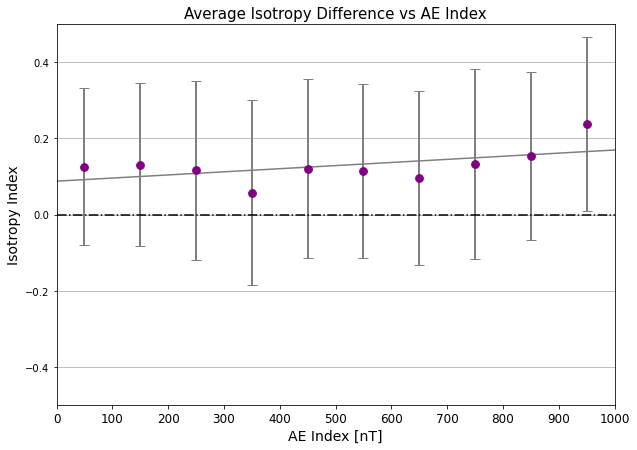

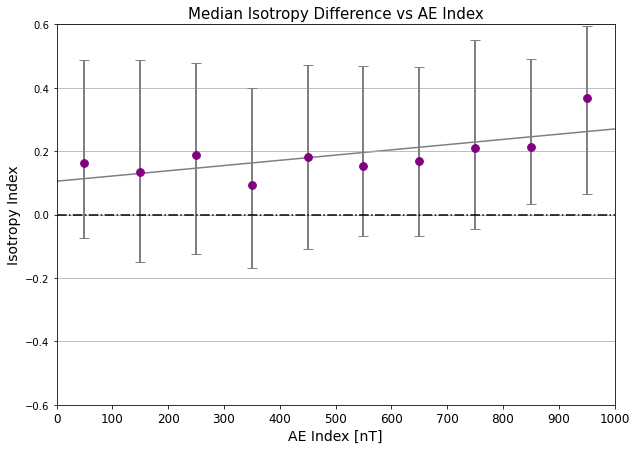

In [12]:
# calculate average iso diff vs AE
iso_diff = iso_MB_avgs_AE - iso_BG_avgs_AE
error_prop = np.sqrt(iso_MB_std_AE**2 + iso_BG_std_AE**2)

plt.figure(figsize = (10,7))
plt.title(f'Average Isotropy Difference vs AE Index', fontsize = 15)

# trendline #
idx = np.isfinite(AE_MB_bin_centers) & np.isfinite(iso_diff)
z = np.polyfit(AE_MB_bin_centers[idx], iso_diff[idx], 1)
p = np.poly1d(z)
x_p = np.linspace(0, np.max(AE_bins))
plt.plot(x_p,p(x_p), color='k', linestyle='-', alpha=0.5, zorder=1)
# trendline #

plt.plot([0,np.max(AE_bins)+np.max(AE_bins)/(2*bin_num)], [0,0], color='k', linestyle='-.')
plt.scatter(AE_MB_bin_centers, iso_diff, c='purple', s = 60, zorder=3)
plt.errorbar(AE_MB_bin_centers, iso_diff, yerr = iso_BG_std_AE, fmt='none', elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(AE_bins))
plt.xticks(ticks=AE_bins, fontsize=12)
plt.xlabel('AE Index [nT]', fontsize=14)
plt.ylim(-0.5,0.5)
plt.ylabel('Isotropy Index', fontsize=14)
plt.grid(axis='y')

# calculate median iso diff vs AE
iso_diff = iso_MB_med_AE - iso_BG_med_AE
error75_prop = np.sqrt(iso_MB_75error_AE**2 + iso_BG_75error_AE**2)
error25_prop = np.sqrt(iso_MB_25error_AE**2 + iso_BG_25error_AE**2)

plt.figure(figsize = (10,7))
plt.title(f'Median Isotropy Difference vs AE Index', fontsize = 15)

# trendline #
idx = np.isfinite(AE_MB_bin_centers) & np.isfinite(iso_diff)
z = np.polyfit(AE_MB_bin_centers[idx], iso_diff[idx], 1)
p = np.poly1d(z)
x_p = np.linspace(0, np.max(AE_bins))
plt.plot(x_p,p(x_p), color='k', linestyle='-', alpha=0.5, zorder=1)
# trendline #

plt.plot([0,np.max(AE_bins)+np.max(AE_bins)/(2*bin_num)], [0,0], color='k', linestyle='-.')
plt.scatter(AE_MB_bin_centers, iso_diff, c='purple', s = 60, zorder=3)
plt.errorbar(AE_MB_bin_centers, iso_diff, yerr = np.array([error25_prop, error75_prop]), fmt='none', \
             elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(AE_bins))
plt.xticks(ticks=AE_bins, fontsize=12)
plt.xlabel('AE Index [nT]', fontsize=14)
plt.ylim(-0.6,0.6)
plt.ylabel('Isotropy Index', fontsize=14)
plt.grid(axis='y')